## Basic Intro to Quantum ML

- The idea is to explore the potential applications of quantum computing in machine learning

### Model

- We'll be looking at using a QCNN (Quantum CNN) for classifying MNIST images. This is a fairly simple dataset, which makes it perfect for to test the efficacy of the Quantum Algorithm. In order to compare the model's performance, we will compare it to [LeNet-5]("http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf"). This model was released in 1998 by Yann LeCun. It was one of the earliest convnets used for image recognition, so it seems reasonable to consider it as a baseline for comparison to the QCNN, which is still in its infancy. `[we can't do this comparison yet]`

- Additionally, we will comapre both a Quantum and Classical Autoencoder


In [1]:
# imports

import torch
import torch.nn as nn
import torch.optim as optim  # used for optimization libraries (SGD, Adam, etc)
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm  # used for progress bars
import matplotlib.pyplot as plt

torch.manual_seed(17)  # computers a (pseudo) random, so specifying a seed allows for reproducibility
None

## Initial Steps (for classical models)

- Define hyperparams and util functions
- Create models
- Create dataloaders
- Train models


In [2]:
# Hyperparameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 1e-3
nb_channels = 16
embedding_dim = 8
batch_size = 64
nb_epochs = 25

In [3]:
# Utils
def plot_imgs(input, output):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(input, cmap="gray")
    ax[0].set_title("Input")
    ax[1].imshow(output, cmap="gray")
    ax[1].set_title("Output")
    plt.show()


def train_autoencoder(model, train_loader, optimizer, nb_epochs):
    for epoch in range(nb_epochs):
        acc_loss = 0
        for batch_idx, data in enumerate(tqdm(train_loader)):
            # send the data to cuda, if possible
            data = data.to(DEVICE)
            output = model(data)
            loss = 0.5 * (output - data).pow(2).sum() / data.size(0)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {acc_loss:.4f}")

In [4]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=6,
            kernel_size=(5, 5),
            stride=(1, 1),
            padding=(0, 0),
        )
        self.conv2 = nn.Conv2d(
            in_channels=6,
            out_channels=16,
            kernel_size=(5, 5),
            stride=(1, 1),
            padding=(0, 0),
        )
        self.conv3 = nn.Conv2d(
            in_channels=16,
            out_channels=120,
            kernel_size=(5, 5),
            stride=(1, 1),
            padding=(0, 0),
        )
        self.linear1 = nn.Linear(120, 84)
        self.linear2 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)

        return x

In [5]:
# we need to reduce the size of the image, so instead of cropping we can use an autoencoder ro reduce the dimensionality
# note: PCA is a linear autoencoder


class AutoEncoder(nn.Module):
    def __init__(self, nb_channels: int, embedding_dim: int):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, nb_channels, kernel_size=5),  # to 24x24 - we are using MNIST
            nn.ReLU(inplace=True),
            nn.Conv2d(nb_channels, nb_channels, kernel_size=5),  # to 20x20
            nn.ReLU(inplace=True),
            nn.Conv2d(nb_channels, nb_channels, kernel_size=4, stride=2),  # to 9x9
            nn.ReLU(inplace=True),
            nn.Conv2d(nb_channels, nb_channels, kernel_size=3, stride=2),  # to 4x4
            nn.ReLU(inplace=True),
            nn.Conv2d(nb_channels, embedding_dim, kernel_size=4),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embedding_dim, nb_channels, kernel_size=4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=3, stride=2),  # from 4x4
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=4, stride=2),  # from 9x9
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=5),  # from 20x20
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(nb_channels, 1, kernel_size=5),  # from 24x24
        )

    def encode(self, x):
        return self.encoder(x).view(x.size(0), -1)

    def decode(self, z):
        return self.decoder(z.view(z.size(0), -1, 1, 1))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [6]:
ae_train_set = datasets.MNIST("data/mnist/", train=True, download=True)
ae_train_dataset = ae_train_set.data.view(-1, 1, 28, 28).float()
mu, std = ae_train_dataset.mean(), ae_train_dataset.std()
ae_train_dataset.sub_(mu).div_(std)
ae_train_loader = DataLoader(dataset=ae_train_dataset, batch_size=batch_size, shuffle=True)

ae_test_set = datasets.MNIST("data/mnist/", train=False, download=True)
ae_test_dataset = ae_test_set.data.view(-1, 1, 28, 28).float()
ae_test_dataset.sub_(mu).div_(std)
None  # we don't need the test_dataset

100%|██████████| 9912422/9912422 [00:00<00:00, 15228489.83it/s]


Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 19013607.57it/s]

Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25123116.09it/s]

Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 3081114.15it/s]

Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = AutoEncoder(nb_channels=nb_channels, embedding_dim=embedding_dim)
autoencoder = autoencoder.to(device)

ae_optimizer = optim.AdamW(autoencoder.parameters(), lr=1e-3)

In [8]:
train_autoencoder(autoencoder, ae_train_loader, ae_optimizer, nb_epochs)

100%|██████████| 938/938 [00:03<00:00, 288.14it/s]


Epoch 1, Loss: 134105.2876


100%|██████████| 938/938 [00:03<00:00, 307.75it/s]


Epoch 2, Loss: 95146.6682


100%|██████████| 938/938 [00:03<00:00, 275.29it/s]


Epoch 3, Loss: 87436.0873


100%|██████████| 938/938 [00:02<00:00, 336.34it/s]


Epoch 4, Loss: 82433.4421


100%|██████████| 938/938 [00:02<00:00, 321.88it/s]


Epoch 5, Loss: 78927.1022


100%|██████████| 938/938 [00:02<00:00, 325.49it/s]


Epoch 6, Loss: 76436.9974


100%|██████████| 938/938 [00:02<00:00, 327.59it/s]


Epoch 7, Loss: 74727.1039


100%|██████████| 938/938 [00:02<00:00, 322.59it/s]


Epoch 8, Loss: 73216.1860


100%|██████████| 938/938 [00:03<00:00, 310.25it/s]


Epoch 9, Loss: 72054.4479


100%|██████████| 938/938 [00:02<00:00, 327.66it/s]


Epoch 10, Loss: 71166.0762


100%|██████████| 938/938 [00:02<00:00, 331.24it/s]


Epoch 11, Loss: 70468.8664


100%|██████████| 938/938 [00:02<00:00, 328.06it/s]


Epoch 12, Loss: 69669.0918


100%|██████████| 938/938 [00:02<00:00, 332.12it/s]


Epoch 13, Loss: 69086.4910


100%|██████████| 938/938 [00:03<00:00, 304.08it/s]


Epoch 14, Loss: 68588.0435


100%|██████████| 938/938 [00:02<00:00, 315.79it/s]


Epoch 15, Loss: 68144.2001


100%|██████████| 938/938 [00:02<00:00, 317.92it/s]


Epoch 16, Loss: 67800.3381


100%|██████████| 938/938 [00:02<00:00, 329.93it/s]


Epoch 17, Loss: 67342.6033


100%|██████████| 938/938 [00:03<00:00, 307.14it/s]


Epoch 18, Loss: 66907.3794


100%|██████████| 938/938 [00:02<00:00, 321.55it/s]


Epoch 19, Loss: 66625.3680


100%|██████████| 938/938 [00:02<00:00, 321.27it/s]


Epoch 20, Loss: 66347.0481


100%|██████████| 938/938 [00:03<00:00, 292.97it/s]


Epoch 21, Loss: 66038.2313


100%|██████████| 938/938 [00:02<00:00, 317.86it/s]


Epoch 22, Loss: 65749.0601


100%|██████████| 938/938 [00:02<00:00, 321.79it/s]


Epoch 23, Loss: 65594.3799


100%|██████████| 938/938 [00:02<00:00, 323.61it/s]


Epoch 24, Loss: 65280.8857


100%|██████████| 938/938 [00:03<00:00, 304.39it/s]

Epoch 25, Loss: 65058.6266


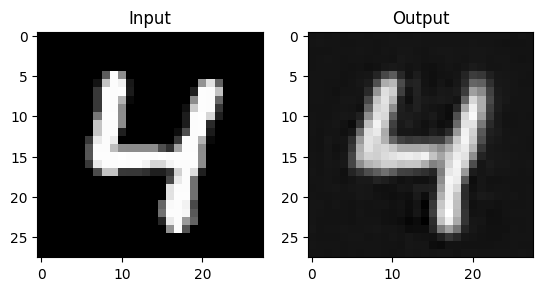

In [9]:
input = ae_test_dataset[56].to(device)

# Encode / decode
z = autoencoder.encode(input)
output = autoencoder.decode(z)

plot_imgs(input.cpu().detach().numpy().squeeze(), output.cpu().detach().numpy().squeeze())

## Quantum Models


### QCNN


In [10]:
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

algorithm_globals.random_seed = 17

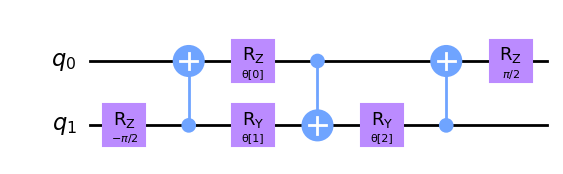

In [11]:
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl", style="clifford")

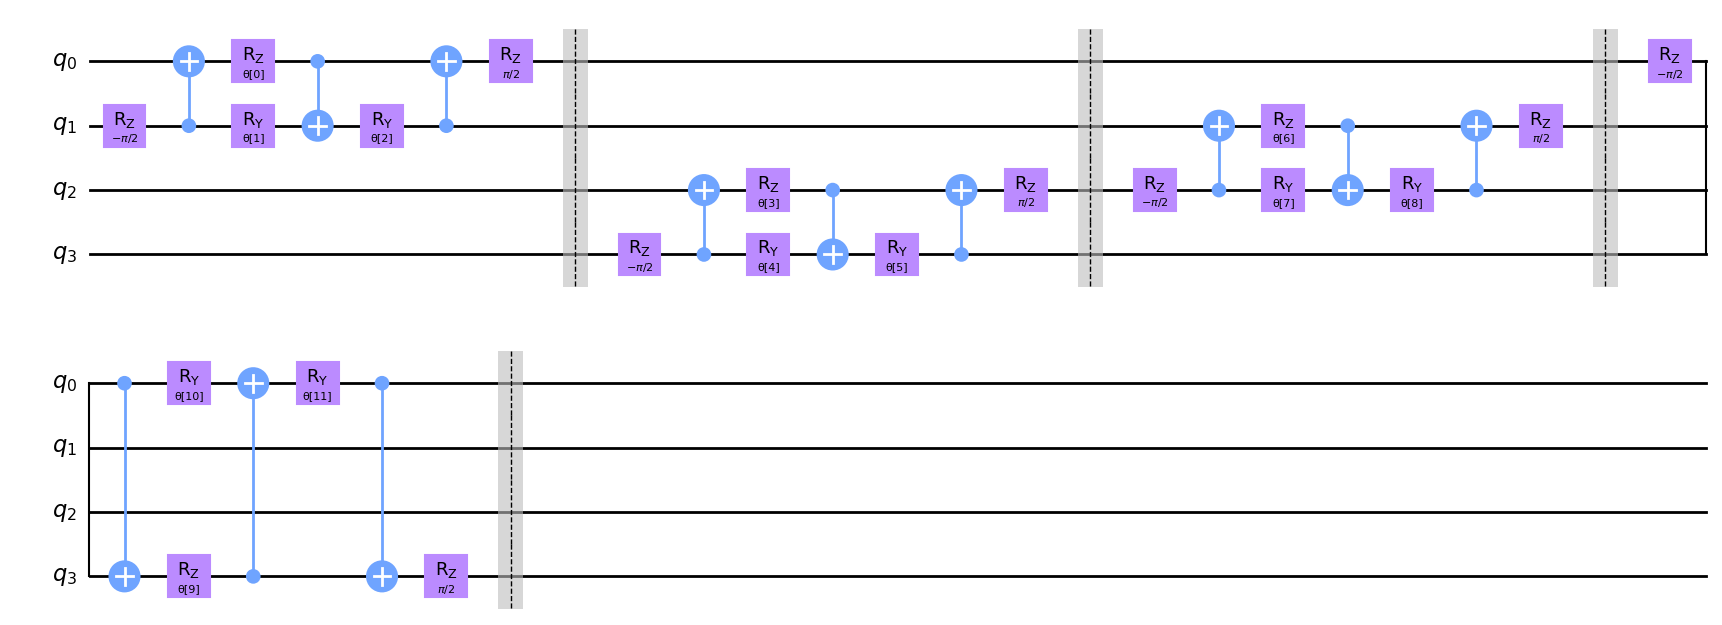

In [12]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl", style="clifford")

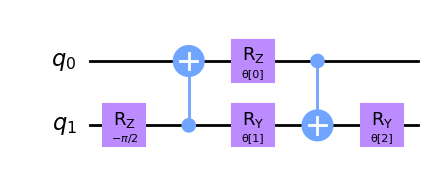

In [13]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl", style="clifford")

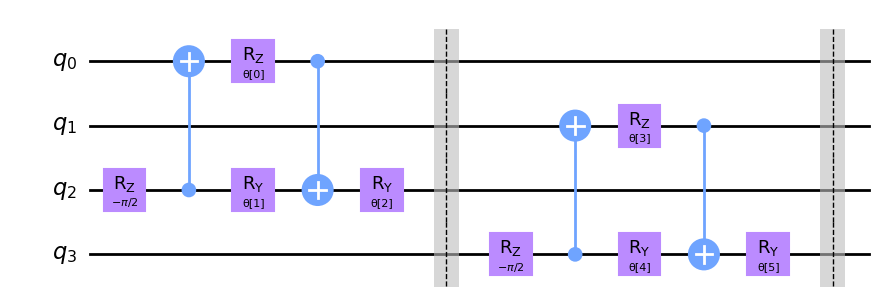

In [14]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl", style="clifford")

In [15]:
# Takes too long to train QCNN

# qcnn_train_set = datasets.MNIST("data/mnist/", train=True, transform=transforms.ToTensor(), download=True)
# qcnn_test_set = datasets.MNIST("data/mnist/", train=False, transform=transforms.ToTensor(), download=True)

# X_train, X_test, y_train, y_test = (
#     qcnn_train_set.data,
#     qcnn_test_set.data,
#     qcnn_train_set.targets,
#     qcnn_test_set.targets,
# )

# X_train = X_train.unsqueeze(1).reshape(-1, 1, 28, 28).to(torch.float32)
# X_test = X_test.unsqueeze(1).reshape(-1, 1, 28, 28).to(torch.float32)

# X_train_encoded = autoencoder.encode(X_train.to(device)).detach().cpu().numpy()
# X_test_encoded = autoencoder.encode(X_test.to(device)).detach().cpu().numpy()
# y_train = y_train.numpy()
# y_test = y_test.numpy()

# X_train_encoded = np.concatenate(
#     (X_train_encoded[np.where(y_train == 3)[0]], X_train_encoded[np.where(y_train == 6)[0]])
# )
# y_train = np.concatenate((y_train[np.where(y_train == 3)[0]], y_train[np.where(y_train == 6)[0]]))

# X_test_encoded = np.concatenate((X_test_encoded[np.where(y_test == 3)[0]], X_test_encoded[np.where(y_test == 6)[0]]))
# y_test = np.concatenate((y_test[np.where(y_test == 3)[0]], y_test[np.where(y_test == 6)[0]]))

# X_train_encoded, y_train = shuffle(X_train_encoded, y_train, random_state=17)
# X_test_encoded, y_test = shuffle(X_test_encoded, y_test, random_state=17)

# # labels/targets need to be 1 and -1
# y_train[y_train == 3] = -1
# y_train[y_train == 6] = 1
# y_test[y_test == 3] = -1
# y_test[y_test == 6] = 1

In [16]:
def generate_dataset(num_images):
    images = []
    labels = []
    hor_array = np.zeros((6, 8))
    ver_array = np.zeros((4, 8))

    j = 0
    for i in range(0, 7):
        if i != 3:
            hor_array[j][i] = np.pi / 2
            hor_array[j][i + 1] = np.pi / 2
            j += 1

    j = 0
    for i in range(0, 4):
        ver_array[j][i] = np.pi / 2
        ver_array[j][i + 4] = np.pi / 2
        j += 1

    for n in range(num_images):
        rng = algorithm_globals.random.integers(0, 2)
        if rng == 0:
            labels.append(-1)
            random_image = algorithm_globals.random.integers(0, 6)
            images.append(np.array(hor_array[random_image]))
        elif rng == 1:
            labels.append(1)
            random_image = algorithm_globals.random.integers(0, 4)
            images.append(np.array(ver_array[random_image]))

        # Create noise
        for i in range(8):
            if images[-1][i] == 0:
                images[-1][i] = algorithm_globals.random.uniform(0, np.pi / 4)
    return images, labels

In [17]:
images, labels = generate_dataset(100)

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.3, random_state=17)

In [18]:
feature_map = ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "c1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

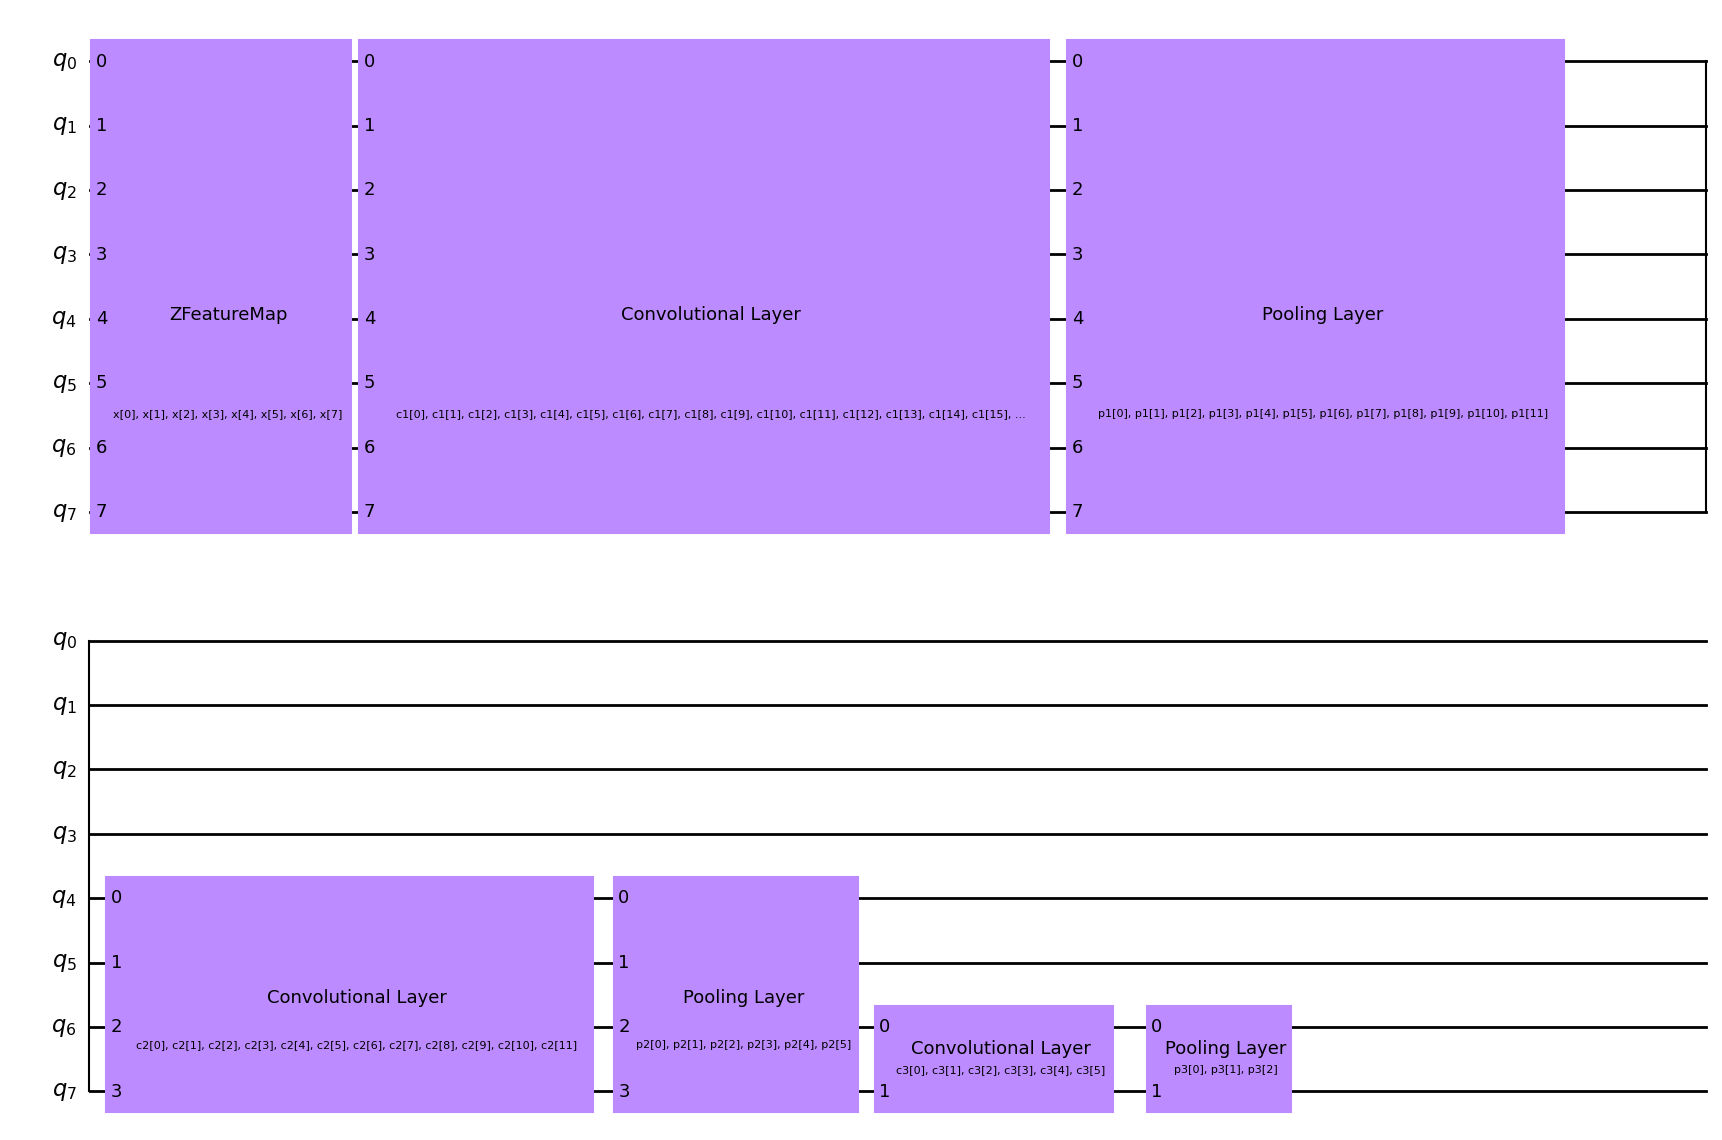

In [19]:
circuit.draw("mpl", style="clifford")

In [20]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [21]:
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=200),  # Set max iterations here
    callback=callback_graph,
)

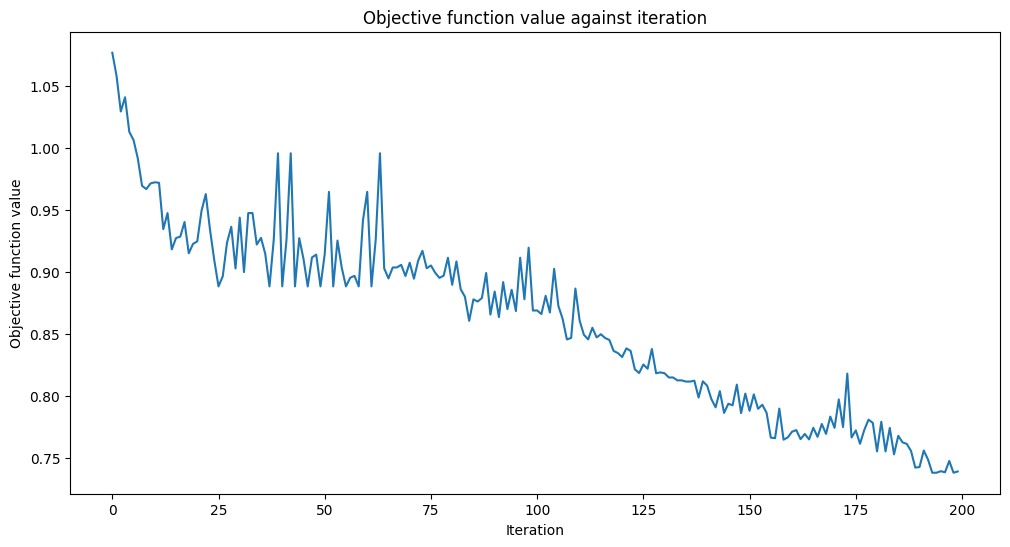

In [24]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
# classifier.fit(X_train_encoded, y_train)

x = np.asarray(train_images)
y = np.asarray(train_labels)
classifier.fit(x, y)

In [25]:
x = np.asarray(test_images)
y = np.asarray(test_labels)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

Accuracy from the test data : 46.67%


### Quantum Autoencoder

- to-do
